# *eht-imaging* Tutorial

---

`eht-imaging` is a Python software for radio interferometric simulation, calibration, analysis, and imaging. Code and documentation can be found on [GitHub](https://github.com/achael/eht-imaging)

This notebook is a simplified version of the imaging process employed by the `eht-imaging` script from the *First M87 EHT Results: Imaging Pipelines* public repository that can be found on [GitHub](https://github.com/eventhorizontelescope/2019-D01-02).

This notebook was originally developed by Antonio Fuentes for the ngEHT Winter 2021 meeting.

[These slides](https://docs.google.com/presentation/d/1A0y9omYI2ueSUa6_t5reylBhw6eiLwjqDzw-HUOk8Ac/edit?usp=sharing) walk through the main steps of the tutorial

## Prerequisites
Running this notebook requires that `eht-imaging` and its dependencies are installed (see README on [GitHub](https://github.com/achael/eht-imaging)). If you do not have `nfft` installed, you can set `ttype=fast` in the following.

## Import necessary modules

In [1]:
import os
import ehtim as eh
import numpy as np
import matplotlib.pyplot as plt

Welcome to eht-imaging! v 1.2.7 



## Define paths

In [2]:
import os
os.getcwd()

'/Users/younghokim/astro/prj4_eht'

In [80]:
inpath  = '/Users/younghokim/astro/prj4_eht'
outpath = '/Users/younghokim/astro/prj4_eht/results'
inobs   = os.path.join(inpath, 'tutorial1_data.uvfits')

# Make output directories
if not os.path.exists(os.path.dirname(outpath)):
    os.makedirs(os.path.dirname(outpath))

## Imaging parameters

In [4]:
prior_fwhm  = 100.*eh.RADPERUAS  # Gaussian prior FWHM (radians)
sys_noise   = 0.01               # fractional systematic noise
                                 # added to complex visibilities

In [5]:
eh.RADPERUAS

4.848136811094136e-12

In [6]:
eh.RADPERAS

4.848136811094136e-06

**eh.RADPERUAS**

- ehtim 패키지에서 사용되는 상수 중 하나로, "radians per microarcsecond"을 의미합니다.

- RADPERUAS는 천문학적 측정에 있어 중요한 단위 변환 상수로 사용됩니다.
-
- 천문학에서는 매우 먼 거리에 있는 천체를 관측할 때, 그 천체의 각크기를 아크초(arcseconds) 또는 더 작은 단위인 마이크로아크초(microarcseconds, μas)로 측정합니다.

In [7]:
reg_term  = {'simple' : 0,       # Maximum-Entropy
             'tv'     : 1,       # Total Variation
             'tv2'    : 0,       # Total Squared Variation
             'l1'     : 1.,      # L1 sparsity prior
             'flux'   : 0.}      # compact flux constraint

In [9]:
data_term = {'amp'    : 1.,      # visibility amplitudes
             'cphase' : 1.,      # closure phases
             'logcamp': 1.}      # log closure amplitudes

In [10]:
ttype     = 'nfft'               # Type of Fourier transform ('direct', 'nfft', or 'fast')
npix      = 100                  # Number of pixels across the reconstructed image
fov       = 700*eh.RADPERUAS     # Field of view of the reconstructed image
maxit     = 350                  # Maximum number of convergence iterations for imaging
niter     = 4                    # Number of imaging iterations
stop      = 1e-6                 # Imager stopping criterion

## Helper function

In [11]:
# Repeat imaging with blurring to assure good convergence
def converge(imgr, major=niter, blur_frac=1.0):
    for repeat in range(major):
        init = imgr.out_last().blur_circ(blur_frac*res)
        imgr.init_next = init
        imgr.make_image_I(show_updates=False)
        imgr.out_last().display(scale='log')
    return imgr

제공된 코드는 converge라는 이름의 helper 함수를 정의하고 있으며, 이미징 프로세스를 반복하여 결과의 수렴성을 향상시키기 위한 목적으로 사용됩니다. 이 함수는 imgr, major, blur_frac를 입력 파라미터로 받으며, 이미지를 반복적으로 생성하고 수정하여 최종적으로 수렴된 이미지를 얻습니다. 각 부분에 대해 자세히 설명하겠습니다:

함수 정의:
```python
def converge(imgr, major=niter, blur_frac=1.0):
```

- **imgr:** 이미징을 수행하는 객체 또는 클래스의 인스턴스입니다. 이 객체는 이미지를 생성하고 수정하는 메소드를 포함하고 있을 것입니다.
- **major:** 이미징을 반복할 횟수를 나타냅니다. 이 값은 함수가 호출될 때 명시적으로 지정되지 않으면 niter라는 변수의 값을 사용합니다.
- **blur_frac:** 블러링(blurring)을 수행할 때 사용되는 계수입니다. 이 값은 이미지를 블러 처리할 정도를 결정하며, 이미지의 해상도에 곱해져 블러의 크기를 결정합니다.

함수 내용:
```python
for repeat in range(major):
    init = imgr.out_last().blur_circ(blur_frac*res)
    imgr.init_next = init
    imgr.make_image_I(show_updates=False)
    imgr.out_last().display(scale='log')
return imgr
```

- **for repeat in range(major)::** 주어진 횟수(major)만큼 이미징 과정을 반복합니다.

- **init = imgr.out_last().blur_circ(blur_frac*res):** 마지막으로 생성된 이미지(out_last())를 가져와서 블러 처리(blur_circ)합니다. 블러 처리는 이미지의 세부 사항을 부드럽게 하여 수렴을 돕습니다.

- **imgr.init_next = init:** 블러 처리된 이미지를 다음 반복에서 초기 이미지로 설정합니다.

- **imgr.make_image_I(show_updates=False):** 새로운 이미지를 생성합니다. show_updates=False는 생성 과정 중 업데이트를 보여주지 않도록 설정합니다.

- **imgr.out_last().display(scale='log'):** 마지막으로 생성된 이미지를 로그 스케일로 표시합니다.

- 전체적인 의미:
converge 함수는 주어진 이미지 생성 객체(imgr)를 사용하여 반복적으로 이미지를 생성하고, 각 반복 후에 이미지를 블러 처리하여 다음 반복의 초기 이미지로 설정합니다. 이 과정은 이미지가 수렴하고, 디테일이 향상되며, 전반적인 이미지 품질이 개선되도록 돕습니다. 함수는 수정된 imgr 객체를 반환하여, 추가적인 처리나 분석이 가능하도록 합니다. 이러한 반복 과정은 특히 복잡한 천문학적 이미지 처리에서 중요한 역할을 할 수 있으며, 더 안정적이고 신뢰성 있는 이미지 결과를 얻는 데 기여할 수 있습니다.

## Data preparation

In [43]:
# Load the uvfits file
obs = eh.obsdata.load_uvfits(inobs)

Loading uvfits:  /Users/younghokim/astro/prj4_eht/tutorial1_data.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!


- **Loading uvfits: /Users/younghokim/astro/prj4_eht/tutorial1_data.uvfits**

> 이 메시지는 사용자가 tutorial1_data.uvfits라는 uvfits 파일을 로드하고 있다는 것을 알려줍니다. 파일 경로는 /Users/younghokim/astro/prj4_eht/입니다.

- **no IF in uvfits header!**

> "IF"는 "Intermediate Frequency"의 약어로, 전파 천문학에서 사용되는 용어입니다. uvfits 파일의 헤더에서 IF 정보가 누락되었다는 경고입니다. IF 정보는 관측된 신호를 변환하는 과정에서 사용되는 주파수를 의미하며, 이 정보가 없으면 데이터를 정확하게 이해하거나 처리하는데 어려움이 있을 수 있습니다.

- **POLREP_UVFITS: circ**

> "POLREP_UVFITS"는 uvfits 파일에서의 편광 표현 방식을 나타냅니다. 여기서 "circ"는 원편광(circular polarization)을 의미합니다. 원편광은 전파의 전기장이 회전하는 방식의 편광으로, 천문학에서 특정 천체나 신호의 특성을 분석할 때 중요할 수 있습니다.

- **Number of uvfits Correlation Products: 4**

> 이 메시지는 uvfits 파일에 4개의 상관 제품(correlation products)이 포함되어 있다는 것을 나타냅니다. 상관 제품은 관측된 데이터의 상관 분석 결과로, 전파 천문학에서 천체의 세부적인 정보를 얻기 위해 사용됩니다.

- **No NX table in uvfits!**

> "NX table"은 uvfits 파일 내에 포함될 수 있는 테이블 중 하나로, 관측 네트워크의 구성이나 배열의 기하학적 구조 등을 기술합니다. 이 메시지는 해당 uvfits 파일에 NX 테이블이 포함되어 있지 않다는 것을 나타냅니다. 이는 파일이 특정 정보를 포함하지 않거나, 다른 방식으로 해당 정보가 제공되고 있음을 의미할 수 있습니다.

In [44]:
type(obs)

ehtim.obsdata.Obsdata

In [45]:
test_arr = obs.data

In [46]:
type(test_arr)

numpy.ndarray

In [47]:
test_arr.shape

(212584,)

In [48]:
# Scan-average the data
# Identify the scans (times of continous observation) in the data
obs.add_scans()

In [49]:
test_arr2 = obs.data

In [50]:
type(test_arr2)

numpy.ndarray

In [51]:
test_arr2.shape

(212584,)

```
add_scans(info='self', filepath='', dt=0.0165, margin=0.0001)[source]¶

```
Compute scans and add self.scans to Obsdata object.

> Parameters
> - info (str) – ‘self’ to infer from data, ‘txt’ for text file, ‘vex’ for vex schedule file
> 
> - filepath (str) – path to txt/vex file with scans info
> 
> - dt (float) – minimal time interval between scans in hours
> 
> - margin (float) – padding scans by that time margin in hours
>


obs.add_scans():

add_scans(): 이 메소드는 로드된 관측 데이터를 스캔으로 조직하거나 재조직하는데 사용될 것으로 보입니다. 전파 천문학에서 "스캔"은 데이터가 지속적으로 수집되는 기간을 의미합니다. 데이터를 스캔으로 조직화하는 것은 데이터를 시간 또는 다른 기준에 따라 의미 있는 부분으로 정렬하는데 중요할 수 있습니다.
이 메소드는 obs 객체를 수정하여 데이터를 스캔으로 추가하거나 조직화합니다. 이렇게 조직된 스캔은 데이터 처리, 보정, 영상화 또는 분석에 사용됩니다.

In [52]:
# Coherently average the scans, which can be averaged due to ad-hoc phasing
obs = obs.avg_coherent(0., scan_avg = True)

/Users/younghokim/anaconda3/envs/astropy2/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 212584 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [54]:
test_arr3 = obs.data
test_arr3.shape

(3592,)

212,584 -> 3,592 행으로 축소

In [55]:
test_arr3

array([(1.38902664e-03, 0., 'AA', 'AP', 0.12      , 0.12      ,  8.72307487e+05, -1.77677099e+06,  0.75837346-0.00732415j,  9.59871224e-05-8.60793484e-05j,  1.67695559e-04-8.70673642e-05j,  9.18557247e-05-7.87520083e-05j, 0.00010712, 0.00010712, 0.00010712, 0.00010712),
       (1.38902664e-03, 0., 'AA', 'CI', 0.12      , 0.31999999, -2.96584957e+09, -3.69146851e+09,  0.10037166-0.00906219j, -1.16966028e-04-4.03396738e-04j, -1.58964265e-04+1.41899320e-05j, -3.38805839e-05-5.48351144e-04j, 0.00022794, 0.00022794, 0.00022794, 0.00022794),
       (1.38902664e-03, 0., 'AA', 'GB', 0.12      , 1.12      , -5.55344836e+09,  5.21749114e+08, -0.00098968-0.04711375j, -2.68137924e-04+1.21802236e-04j,  2.14636090e-04-1.02708425e-04j, -5.60930229e-05+2.16904407e-04j, 0.00016378, 0.00016378, 0.00016378, 0.00016378),
       ...,
       (2.36680555e+01, 0., 'PV', 'GL', 0.40000001, 0.12      ,  7.62510105e+08, -2.51239511e+09,  0.16276066+0.05794316j, -3.28239343e-04+1.37876267e-04j,  4.74126576e-04-1.7

```python

avg_coherent(inttime, scan_avg=False, moving=False)[source]

```

Coherently average data along u,v tracks in chunks of length inttime (sec)

Parameters
- inttime (float) – coherent integration time in seconds

- scan_avg (bool) – if True, average over scans in self.scans instead of intime

- moving (bool) – averaging with moving window (boxcar width in seconds)

Returns
- Obsdata object containing averaged data

Return type
- (Obsdata)

---------

obs.avg_coherent() 함수는 ObsData 객체의 데이터를 일정 시간 동안 또는 스캔별로 일관성 있게(coherently) 평균화하는데 사용됩니다. 
> "일관성 있게 평균화한다"는 것은 u-v 트랙(전파 천문학에서 사용되는 좌표계)을 따라 데이터를 세밀하게 평균내는 과정을 의미합니다. 
>
> 이 기능은 데이터에서 노이즈를 줄이고 신호를 강화하는 데 도움이 됩니다. 각 매개변수와 함수의 역할을 한국어로 자세히 설명하겠습니다:


> - inttime (float): 이것은 일관된 통합 시간을 초 단위로 설정합니다. 즉, 데이터를 얼마나 자주 평균낼지를 결정하는 시간 간격입니다. 예를 들어, inttime이 10초로 설정되면, 10초마다의 데이터를 일관성 있게 평균내게 됩니다.
>
> - scan_avg (bool): 이 매개변수가 True로 설정되면, 함수는 inttime을 기반으로 평균내는 대신 각 스캔에 대해 평균을 계산합니다. 스캔은 관측 데이터가 지속적으로 수집되는 기간을 의미하며, 각 스캔별로 데이터를 평균내면, 각 스캔의 전체 데이터를 대표하는 단일 값이 생성됩니다.
>
> - moving (bool): 이것은 이동 평균을 사용할지 여부를 결정합니다. 이동 평균은 평균을 계산할 때 주어진 시간(window)을 데이터 포인트 주위로 이동하면서 계산하는 방식입니다. 이는 데이터의 변화를 더 부드럽게 표현할 수 있도록 합니다.
>
> - 반환값은 평균화된 데이터를 포함하는 새로운 ObsData 객체입니다. 이 객체는 원본 데이터보다 더 단순화되거나 노이즈가 줄어든 형태일 것입니다.
> 
> 간단히 말해서, obs.avg_coherent(0., scan_avg=True) 호출은 ObsData 객체인 obs에서 각 스캔별로 데이터를 일관성 있게 평균내는 동작을 수행하고, 그 결과로 새로운 ObsData 객체를 반환합니다. 이 과정은 데이터를 분석하기 전에 전처리 단계에서 주로 사용되며, 데이터의 크기를 줄이고 중요한 신호를 보다 명확하게 할 수 있도록 도와줍니다.

In [57]:
# Estimate the total flux density from the ALMA(AA) -- APEX(AP) zero baseline
zbl = np.median(obs.unpack_bl('AA','AP','amp')['amp'])

In [58]:
type(zbl)

numpy.float64

In [60]:
# 계산된 중앙값을 zbl 객체에 저장한 결과를 확인

zbl

0.7581894017217471

unpack_bl(site1, site2, fields, ang_unit='deg', debias=False, timetype=False)[source]

Unpack the data over time on the selected baseline site1-site2.

Parameters
- site1 (str) – First site name

- site2 (str) – Second site name

- fields (list) – list of unpacked quantities from available quantities in FIELDS

- ang_unit (str) – ‘deg’ for degrees and ‘rad’ for radian phases

- debias (bool) – True to debias visibility amplitudes

- timetype (str) – ‘GMST’ or ‘UTC’ changes what is returned for ‘time’

Returns
- unpacked numpy array with data in fields requested

Return type
- (numpy.recarray)

`obs.unpack_bl()` 함수는 ObsData 객체인 obs에서 지정된 기준(baseline)에 따라 데이터를 추출하는 기능을 수행합니다. 
코드 zbl = np.median(obs.unpack_bl('AA','AP','amp')['amp'])는 특정 두 관측지점 사이의 데이터를 추출하고, 
그 중 'amp' (아마도 amplitude) 데이터의 중앙값을 계산하여 zbl 변수에 저장하는 작업을 수행합니다. 각 부분을 자세히 설명하겠습니다:

unpack_bl(site1, site2, fields, ang_unit='deg', debias=False, timetype=False)

1. **site1 (str), site2 (str):**
- site1과 site2는 천문학적 관측 네트워크에서의 두 관측 장소를 의미합니다. 'AA'와 'AP'는 이들 장소의 식별자입니다. 이 두 지점 사이의 baseline 데이터를 추출합니다.

2. **fields (list):**
- 이 인자는 추출할 데이터의 유형을 지정합니다. 예제에서는 'amp'라는 단일 필드가 지정되어 있으며, 이는 아마도 진폭(Amplitude) 데이터를 나타냅니다. fields는 'amp', 'phase', 'snr' 등과 같은 다양한 데이터 유형 중에서 선택할 수 있습니다.
  
3. **ang_unit (str):**
- 각도 단위를 지정합니다. 'deg'는 도(degree), 'rad'는 라디안(radian)을 의미합니다. 이것은 주로 위상(phase) 데이터를 처리할 때 중요합니다.

4. **debias (bool):**
- 진폭(amplitudes)을 "debias"할지 여부를 지정합니다. True로 설정하면, 진폭의 편향을 제거하는 처리가 이루어질 수 있습니다. 이는 데이터의 정확성을 향상시킬 수 있습니다.

5. **timetype (str):** 
- 'GMST' 또는 'UTC'를 지정하여 반환되는 'time' 데이터의 형식을 결정합니다. GMST는 그린위치 평균시, UTC는 협정 세계시를 의미합니다.

코드의 기능:

> - obs.unpack_bl('AA','AP','amp'): 'AA'와 'AP' 사이의 baseline 데이터에서 'amp' 필드(진폭 데이터)를 추출합니다.
> 
> - `['amp']`: 추출된 데이터에서 'amp'에 해당하는 부분만을 선택합니다.
> 
> - np.median(...): 선택된 'amp' 데이터의 중앙값을 계산합니다.

zbl = ...: 계산된 중앙값을 zbl 변수에 저장합니다.
이러한 과정을 통해, 지정된 두 관측 장소 사이의 진폭 데이터에서 통계적으로 중앙에 위치하는 값을 추출할 수 있습니다. 이는 데이터의 대표적인 특성을 파악하거나, 이상치의 영향을 줄이기 위해 사용될 수 있습니다. 이러한 데이터 처리는 특히 복잡한 천문학적 데이터를 분석할 때, 데이터를 요약하고 이해하는 데 유용합니다.








In [61]:
obs.tkey

{'AA': 0,
 'AP': 1,
 'PV': 2,
 'GB': 3,
 'GL': 4,
 'PB': 5,
 'CI': 6,
 'HA': 7,
 'SG': 8,
 'CT': 9,
 'LM': 10,
 'AZ': 11,
 'KP': 12,
 'GR': 13,
 'BA': 14,
 'BR': 15,
 'OV': 16,
 'JC': 17,
 'SM': 18,
 'NZ': 19}

In [63]:
obs.tarr

array([('AA',  2225060.8136 , -5440059.59994, -2481681.15054, 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('AP',  2225039.5297 , -5441197.6292 , -2479303.3597 , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('PV',  5088967.74544,  -301681.18586,  3825012.20561, 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('GB',  5627890.     ,  1637767.     , -2512493.     , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('GL',   541647.     , -1388536.     ,  6180829.     , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('PB',  4523951.     ,   468037.     ,  4460264.     , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('CI',  5311000.     , -1725000.     ,  3075000.     , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('HA',  1521000.     , -4417000.     ,  4327000.     , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('SG',  1832000.     , -5034000.     , -3455000.     , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('CT',  1569000.     , -4559000.     , -4163000.     , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('L

In [64]:
# Flag out sites in the obs.tarr table with no measurements
allsites = set(obs.unpack(['t1'])['t1'])|set(obs.unpack(['t2'])['t2'])

각 부분의 설명:
obs.unpack(['t1'])['t1']:

obs.unpack(['t1']): obs 객체에서 't1' 필드의 데이터를 추출합니다. 여기서 't1'은 천문학 데이터에서 일반적으로 사용되는 표현으로, baseline의 한쪽 끝에 해당하는 관측 사이트를 의미할 수 있습니다.
['t1']: 추출된 데이터 중에서 't1'에 해당하는 부분을 선택합니다.
obs.unpack(['t2'])['t2']:

마찬가지로, obs.unpack(['t2'])는 't2' 필드의 데이터를 추출합니다. 't2'는 't1'과 함께 baseline의 다른 쪽 끝을 나타내는 관측 사이트를 의미합니다.
['t2']: 추출된 데이터 중에서 't2'에 해당하는 부분을 선택합니다.
set(obs.unpack(['t1'])['t1']) | set(obs.unpack(['t2'])['t2']):

set(...): 각각의 추출된 데이터를 집합(set)으로 변환합니다. 집합은 중복을 허용하지 않으므로, 각 사이트의 고유한 목록을 얻을 수 있습니다.
|: 두 집합의 합집합을 구합니다. 이 연산은 't1'과 't2'에서 얻은 모든 고유 사이트를 하나의 집합으로 합치는데 사용됩니다.
전체적인 의미:
이 코드는 obs 객체의 't1'과 't2' 필드에서 모든 고유 사이트를 추출하고, 이들을 하나의 집합으로 결합합니다. 결과적으로 allsites 변수는 모든 관측 사이트의 고유한 목록을 포함하게 됩니다. 이 집합은 후속 처리에서 측정치가 없는 사이트를 식별하고 제외하는데 사용될 수 있습니다. 예를 들어, 데이터 분석 중에 특정 사이트에서의 데이터가 없거나 불완전할 경우, 이를 처리하기 위한 기준으로 allsites를 사용할 수 있습니다.

In [65]:
allsites

{'AA',
 'AP',
 'AZ',
 'BA',
 'BR',
 'CI',
 'CT',
 'GB',
 'GL',
 'GR',
 'HA',
 'JC',
 'KP',
 'LM',
 'NZ',
 'OV',
 'PB',
 'PV',
 'SG',
 'SM'}

In [66]:
obs.tarr['site']

array(['AA', 'AP', 'PV', 'GB', 'GL', 'PB', 'CI', 'HA', 'SG', 'CT', 'LM',
       'AZ', 'KP', 'GR', 'BA', 'BR', 'OV', 'JC', 'SM', 'NZ'], dtype='<U32')

In [69]:

obs.tarr = obs.tarr[[o in allsites for o in obs.tarr['site']]]

In [70]:
obs.tarr

array([('AA',  2225060.8136 , -5440059.59994, -2481681.15054, 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('AP',  2225039.5297 , -5441197.6292 , -2479303.3597 , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('PV',  5088967.74544,  -301681.18586,  3825012.20561, 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('GB',  5627890.     ,  1637767.     , -2512493.     , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('GL',   541647.     , -1388536.     ,  6180829.     , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('PB',  4523951.     ,   468037.     ,  4460264.     , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('CI',  5311000.     , -1725000.     ,  3075000.     , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('HA',  1521000.     , -4417000.     ,  4327000.     , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('SG',  1832000.     , -5034000.     , -3455000.     , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('CT',  1569000.     , -4559000.     , -4163000.     , 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('L

In [71]:
obs = eh.obsdata.Obsdata(obs.ra, obs.dec, obs.rf, obs.bw, obs.data, obs.tarr,
                         source=obs.source, mjd=obs.mjd,
                         ampcal=obs.ampcal, phasecal=obs.phasecal)

In [73]:
obs.data

array([(1.38902664e-03, 0., 'AA', 'AP', 0.12      , 0.12      ,  8.72307487e+05, -1.77677099e+06,  0.75837346-0.00732415j,  9.59871224e-05-8.60793484e-05j,  1.67695559e-04-8.70673642e-05j,  9.18557247e-05-7.87520083e-05j, 0.00010712, 0.00010712, 0.00010712, 0.00010712),
       (1.38902664e-03, 0., 'AA', 'CI', 0.12      , 0.31999999, -2.96584957e+09, -3.69146851e+09,  0.10037166-0.00906219j, -1.16966028e-04-4.03396738e-04j, -1.58964265e-04+1.41899320e-05j, -3.38805839e-05-5.48351144e-04j, 0.00022794, 0.00022794, 0.00022794, 0.00022794),
       (1.38902664e-03, 0., 'AA', 'GB', 0.12      , 1.12      , -5.55344836e+09,  5.21749114e+08, -0.00098968-0.04711375j, -2.68137924e-04+1.21802236e-04j,  2.14636090e-04-1.02708425e-04j, -5.60930229e-05+2.16904407e-04j, 0.00016378, 0.00016378, 0.00016378, 0.00016378),
       ...,
       (2.36680555e+01, 0., 'PV', 'GL', 0.40000001, 0.12      ,  7.62510105e+08, -2.51239511e+09,  0.16276066+0.05794316j, -3.28239343e-04+1.37876267e-04j,  4.74126576e-04-1.7

In [74]:
obs.data.shape

(3592,)

In [75]:
obs_orig = obs.copy() # save obs before any further modifications

In [76]:
obs_orig

In [77]:
obs

obs_orig와 obs 간 메모리 주소가 다른 점을 확인

In [78]:
# Order the stations by SNR.
# This will create a minimal set of closure quantities
# with the highest snr and smallest covariance.
obs.reorder_tarr_snr()


이 코드는 obs.reorder_tarr_snr() 함수를 호출하여 obs 객체의 관측 장소(또는 스테이션)들을 신호 대 잡음비(Signal-to-Noise Ratio, SNR)에 따라 재정렬하는 작업을 수행합니다. 이 함수는 ObsData 객체의 관측 테이블(tarr)을 SNR이 높은 순서로 재정렬하는데 사용됩니다. 이를 통해 더 높은 SNR을 가진 관측 데이터를 우선시하고, 클로저 양(closure quantities)의 최소 집합을 생성하는데 도움이 됩니다. 각 부분에 대해 자세히 설명하겠습니다:

**함수의 기능:**
신호 대 잡음비(SNR) 재정렬: 이 함수는 각 관측 스테이션의 신호 대 잡음비를 기준으로 관측 테이블(tarr)을 재정렬합니다. SNR은 관측된 신호의 품질을 나타내는 중요한 척도로, 값이 높을수록 신호의 질이 좋다고 간주합니다.

**클로저 양 최소화:**
클로저 양은 여러 관측 스테이션을 통과하는 신호의 위상(phase) 또는 진폭(amplitude)과 같은 관측량의 조합을 의미합니다. 이러한 양은 특히 VLBI(Very Long Baseline Interferometry)에서 중요하며, 장비나 대기 조건 등의 오류로부터 독립적인 천체의 특성을 추출하는 데 사용됩니다. 함수의 목적 중 하나는 가능한 가장 높은 SNR을 가지고, 공분산이 작은 클로저 양의 최소 집합을 생성하는 것입니다.

**전체적인 의미:**
obs.reorder_tarr_snr() 함수 호출은 obs 객체에 저장된 관측 데이터를 더 효과적으로 분석하고 사용하기 위한 전처리 단계입니다. 관측 스테이션들을 SNR에 따라 재정렬함으로써, 데이터 분석 시 더 정확하고 신뢰성 있는 결과를 얻을 수 있도록 돕습니다. 또한, 이는 클로저 양 분석에서 중요한 요소인 공분산을 최소화하는 데에도 기여할 수 있으며, 전반적인 데이터의 품질을 향상시키는 데 도움을 줄 수 있습니다. 데이터를 재정렬하는 이러한 작업은 특히 복잡한 천문학적 데이터를 다룰 때, 데이터의 신뢰도와 분석의 정확성을 높이는 데 중요한 역할을 합니다.


## Data inspection

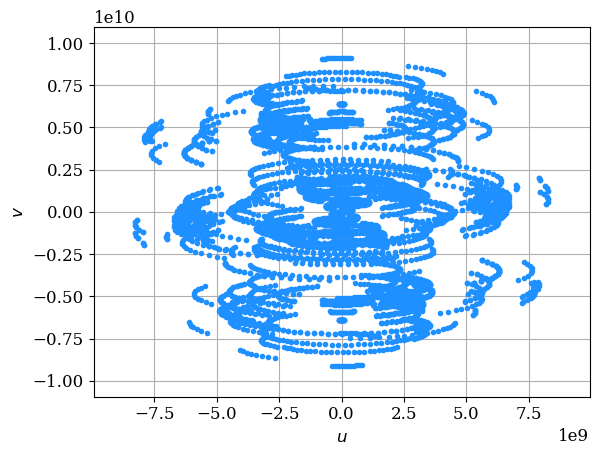

<Axes: xlabel='$u$', ylabel='$v$'>

In [81]:
# Plot uv-coverage
obs.plotall('u', 'v', conj=True, export_pdf=outpath+'uv.pdf')

```python
plotall(field1, field2, conj=False, debias=False, tag_bl=False, ang_unit='deg', timetype=False, axis=False, rangex=False, rangey=False, snrcut=0.0, color=0.11764705882352941, 0.5647058823529412, 1.0, marker='o', markersize=3, label=None, grid=True, ebar=True, axislabels=True, legend=False, show=True, export_pdf='')[source]¶
Plot two fields against each other.
```

**Parameters**
- field1 (str) – x-axis field (from FIELDS)
- field2 (str) – y-axis field (from FIELDS)
- conj (bool) – Plot conjuage baseline data points if True
- debias (bool) – If True, debias amplitudes.
- tag_bl (bool) – if True, label each baseline
- ang_unit (str) – phase unit ‘deg’ or ‘rad’
- timetype (str) – ‘GMST’ or ‘UTC’
- axis (matplotlib.axes.Axes) – add plot to this axis
- rangex (list) – [xmin, xmax] x-axis limits
- rangey (list) – [ymin, ymax] y-axis limits
- color (str) – color for scatterplot points
- marker (str) – matplotlib plot marker
- markersize (int) – size of plot markers
- label (str) – plot legend label
- snrcut (float) – flag closure amplitudes with snr lower than this
- grid (bool) – Plot gridlines if True
- ebar (bool) – Plot error bars if True
- axislabels (bool) – Show axis labels if True
- legend (bool) – Show legend if True
- show (bool) – Display the plot if true
- export_pdf (str) – path to pdf file to save figure

**Returns**
Axes object with data plot

**Return type**
(matplotlib.axes.Axes)

제공된 코드 obs.plotall('u', 'v', conj=True, export_pdf=outpath+'uv.pdf')는 ObsData 객체인 obs를 사용하여 UV 커버리지(UV-coverage)를 플롯하는 작업을 수행합니다. UV 커버리지는 천문학에서 관측된 데이터가 u-v 평면(주파수 공간)에서 어떻게 분포하는지를 보여주는 그래프로, 관측의 품질과 이미지 복원 능력에 중요한 정보를 제공합니다. 각 부분에 대해 자세히 설명하겠습니다:

**코드:**
```python
obs.plotall('u', 'v', conj=True, export_pdf=outpath+'uv.pdf')
```

**각 부분의 설명:**

1. obs.plotall(...):
- plotall은 ObsData 객체인 obs의 메소드로, 데이터를 시각화하기 위해 사용됩니다. 이 메소드는 다양한 데이터 포인트를 플롯할 때 사용되며, 특히 여러 변수 또는 차원에 걸쳐 데이터를 시각화할 때 유용합니다.
 
2. 'u', 'v':
- 이 인자들은 플롯할 데이터의 축을 지정합니다. 여기서 'u'와 'v'는 u-v 평면의 좌표를 나타냅니다. 전파 천문학에서 u-v 평면은 관측된 신호의 공간 주파수 분포를 나타내며, 각 포인트는 관측된 천체 또는 신호의 특정 정보를 포함합니다.

3. conj=True:
- 이 옵션은 플롯에 복소 공액(complex conjugate) 포인트를 포함시킬지 여부를 결정합니다. 복소 공액 포인트를 포함시키면 u-v 평면의 대칭성을 높일 수 있으며, 이는 데이터의 해석을 돕고, 관측의 완전성을 더 잘 나타낼 수 있습니다.

4. export_pdf=outpath+'uv.pdf':
- export_pdf 옵션은 생성된 플롯을 PDF 파일로 내보내는 기능을 활성화합니다. outpath+'uv.pdf'는 PDF 파일이 저장될 경로와 파일 이름을 지정합니다. outpath는 PDF를 저장할 경로를 나타내는 변수이며, 이 경로에 'uv.pdf'라는 이름으로 파일이 저장됩니다.

**전체적인 의미:**
> obs.plotall 함수 호출은 UV 커버리지를 시각화하고, 해당 그래프를 PDF 형식으로 저장하는 작업을 수행합니다. 이러한 UV 커버리지 플롯은 관측의 품질을 평가하고, 이미징 과정에서 데이터가 어떻게 사용될지에 대한 통찰을 제공할 수 있습니다. 또한, 데이터의 공간 주파수 분포를 시각적으로 나타내어 천문학자들이 관측 계획을 세우거나 이미지 복원 알고리즘을 개선하는 데 도움을 줄 수 있습니다.

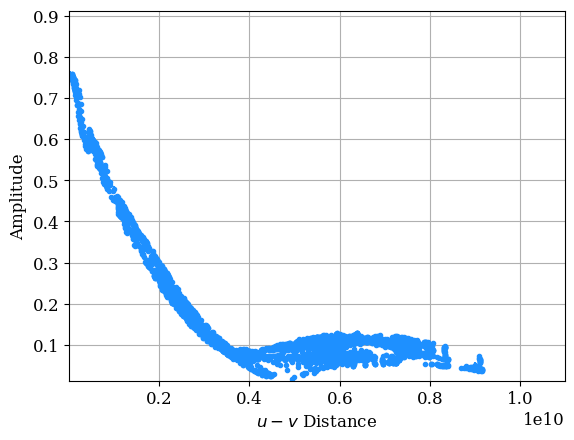

<Axes: xlabel='$u-v$ Distance', ylabel='Amplitude'>

In [82]:
# Plot visibility amplitudes, phases, etc. as a function of uv distance
obs.plotall('uvdist', 'amp', export_pdf=outpath+'amps.pdf')

# Plot baselines
#obs.plot_bl('AA', 'SM', 'phase', rangex=[4., 10])

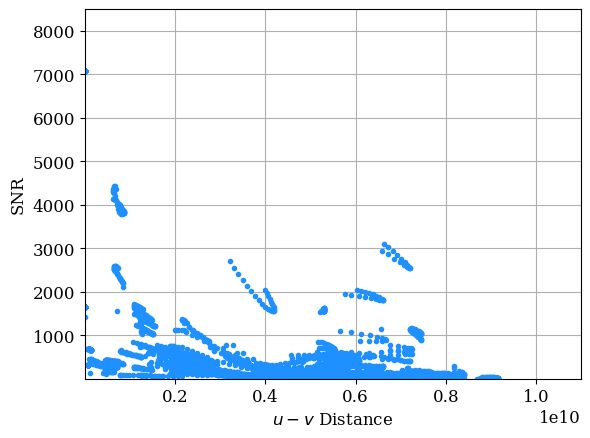

<Axes: xlabel='$u-v$ Distance', ylabel='SNR'>

In [84]:
# Other possible fields include “snr”, “sigma”, “qamp”, ”uamp”, ”vamp” , “m”

obs.plotall('uvdist', 'snr')

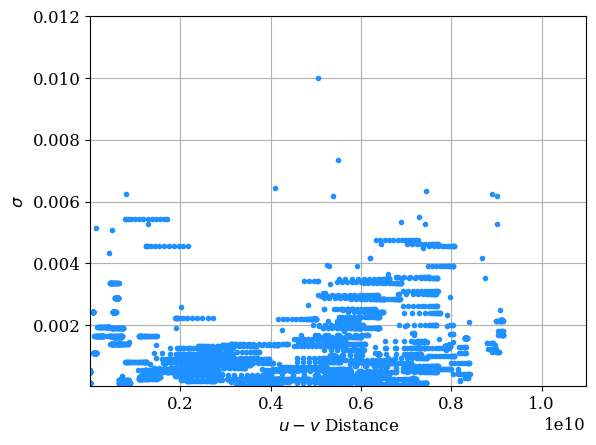

<Axes: xlabel='$u-v$ Distance', ylabel='$\\sigma$'>

In [85]:
# Other possible fields include “snr”, “sigma”, “qamp”, ”uamp”, ”vamp” , “m”

obs.plotall('uvdist', 'sigma')

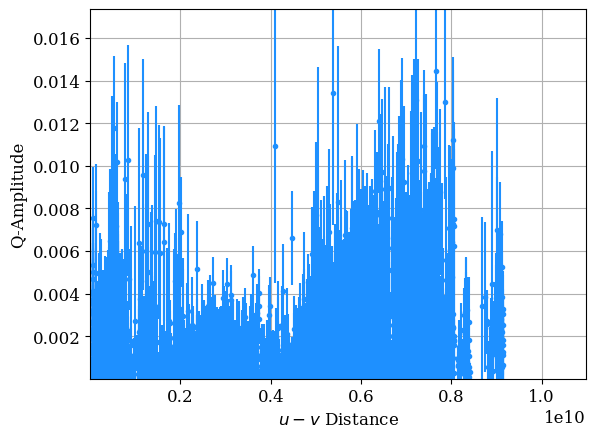

<Axes: xlabel='$u-v$ Distance', ylabel='Q-Amplitude'>

In [86]:
# Other possible fields include “snr”, “sigma”, “qamp”, ”uamp”, ”vamp” , “m”

obs.plotall('uvdist', 'qamp')

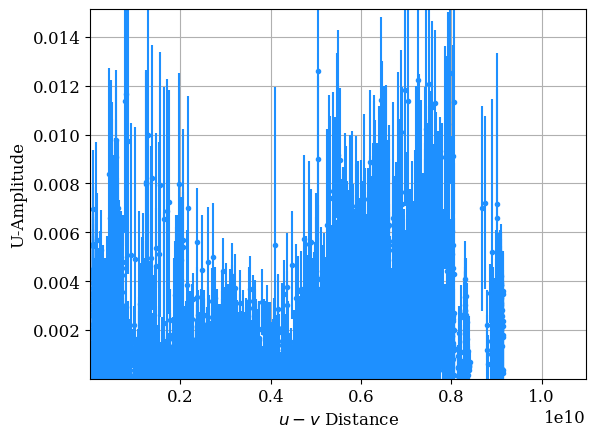

<Axes: xlabel='$u-v$ Distance', ylabel='U-Amplitude'>

In [87]:
# Other possible fields include “snr”, “sigma”, “qamp”, ”uamp”, ”vamp” , “m”

obs.plotall('uvdist', 'uamp')

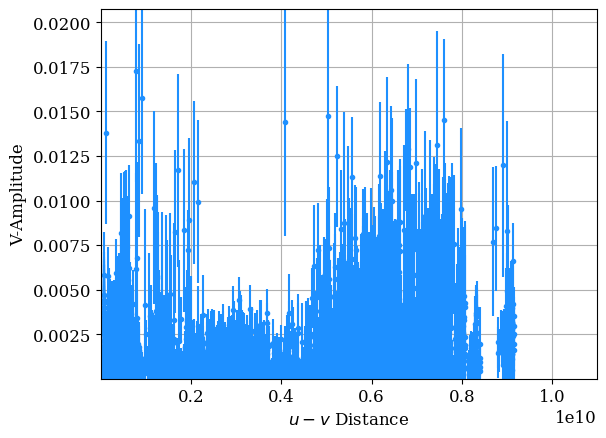

<Axes: xlabel='$u-v$ Distance', ylabel='V-Amplitude'>

In [88]:
# Other possible fields include “snr”, “sigma”, “qamp”, ”uamp”, ”vamp” , “m”

obs.plotall('uvdist', 'vamp')

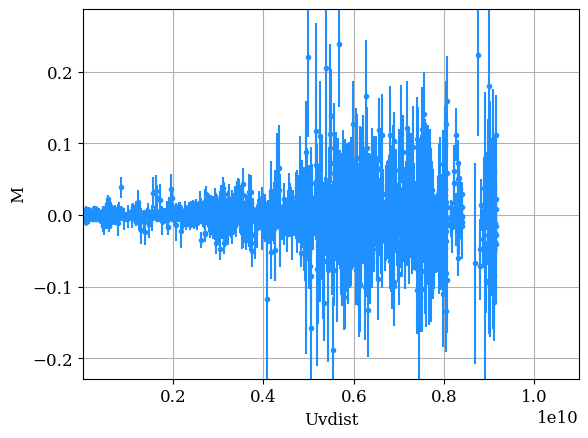

<Axes: xlabel='Uvdist', ylabel='M'>

In [89]:
# Other possible fields include “snr”, “sigma”, “qamp”, ”uamp”, ”vamp” , “m”

obs.plotall('uvdist', 'm')

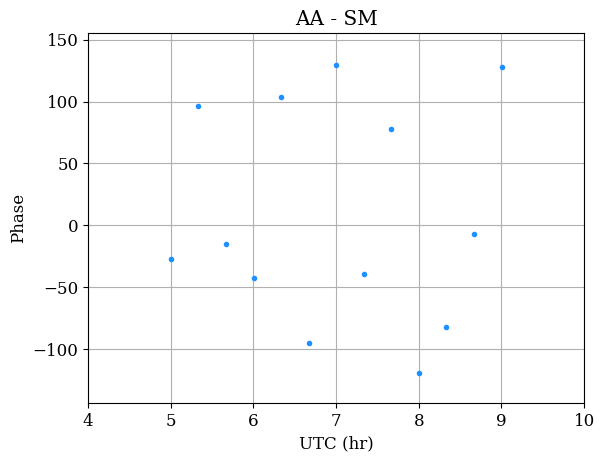

<Axes: title={'center': 'AA - SM'}, xlabel='UTC (hr)', ylabel='Phase'>

In [90]:
# Plot baselines
obs.plot_bl('AA', 'SM', 'phase', rangex=[4., 10])

## Define prior/init and noise budget

In [91]:
obs_sc = obs.copy() # From here on out, don't change obs. Use obs_sc to track gain changes
res    = obs.res()  # The nominal array resolution: 1/(longest baseline)

In [92]:
# Make a Gaussian prior image for maximum entropy regularization
# This Gaussian is also the initial image

# 1. Make an empty square image.
gaussprior = eh.image.make_square(obs_sc, npix, fov)

# 2. Add an gaussian to an image
gaussprior = gaussprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0., 170*eh.RADPERUAS, -170*eh.RADPERUAS))



In [93]:
gaussprior

```python
gaussprior = gaussprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0., 170*eh.RADPERUAS, -170*eh.RADPERUAS))
```
gaussprior 이미지 객체에 가우시안(Gaussian)을 추가하는 작업을 수행합니다. 이 과정은 종종 이미지 처리나 분석에서 특정 형태의 구조를 이미지에 도입할 때 사용됩니다. 각 부분에 대해 자세히 설명하겠습니다:

**함수:**
- add_gauss(flux, beamparams, pol=None): 이 함수는 이미지에 가우시안 형태의 구조를 추가합니다.

- 파라미터:
    + flux (float): 가우시안에 포함될 전체 플럭스(밝기)를 지정합니다. zbl이 이 값을 나타내며, 이는 일반적으로 조영(Jansky, Jy) 단위로 표시되는 밝기 또는 신호의 양입니다.

    + beamparams (list): 가우시안의 형태를 정의하는 파라미터들을 포함하는 리스트입니다. 이는 다음과 같은 순서로 구성됩니다:

    + pol (str): 가우시안을 추가할 편광을 지정합니다. 기본값인 None은 pol_prim으로 설정됩니다. 이 예제에서는 pol이 명시적으로 제공되지 않았기 때문에 기본값을 사용하게 됩니다.

**전체적인 의미:**
이 코드는 gaussprior 이미지에 특정 위치에 특정 크기와 방향을 가진 가우시안 구조를 추가합니다. 특히, zbl로 지정된 밝기로, prior_fwhm의 주요 및 부차적 축을 가지고, 지정된 위치에 추가됩니다. 이러한 추가는 이미지에 특정 형태의 특징을 도입하거나, 예상되는 관측 결과를 모델링하는 데 사용될 수 있습니다. 가우시안은 천문학적 관측데이터에서 볼 수 있는 형태나 소스를 모델링하는 데 자주 사용되는데, 이는 그러한 소스들이 가우시안 형태의 밝기 분포를 가지는 경우가 많기 때문입니다. 결과적으로, 이 코드는 관측 이미지 또는 모델에 특정 구조적 특징을 추가하는 데 사용될 수 있습니다.

In [94]:
# Add a large disk to capture extended emission
gaussprior = gaussprior.add_tophat(zbl*0.1, fov/2).blur_circ(res)



gaussprior = gaussprior.add_tophat(zbl*0.1, fov/2).blur_circ(res)는 이미지에 중앙에 위치한 톱햇(Tophat) 형태의 구조를 추가하고, 결과 이미지를 특정 해상도로 블러 처리하는 작업을 수행합니다. 이 과정은 주로 확장된 방출 또는 배경의 방출을 포착하기 위해 사용됩니다. 각 부분에 대해 자세히 설명하겠습니다:

함수:
add_tophat(flux, radius, pol=None):
이 함수는 이미지에 중앙에 위치한 톱햇 형태의 구조를 추가합니다. 톱햇은 특정 반지름 내에서 일정한 밝기를 가지고, 그 밖으로는 0의 밝기를 가지는 구조입니다.
파라미터:
flux (float): 이미지에 추가할 총 플럭스(밝기)입니다. 여기서는 zbl*0.1로, 원래 가우시안 구조의 밝기 zbl의 10%를 사용합니다.

radius (float): 톱햇 구조의 반지름을 지정합니다. 여기서는 fov/2로 설정되어 있으며, fov는 이미지의 시야(Field of View)를 나타냅니다. 따라서 톱햇의 반지름은 시야의 절반 크기로 설정됩니다.

pol (str): 톱햇 구조를 추가할 편광을 지정합니다. 여기서는 명시적으로 제공되지 않았으므로 기본값인 pol_prim을 사용합니다.

이어진 처리:
.blur_circ(res): add_tophat으로 추가된 이미지에 대해 블러 처리를 수행합니다. blur_circ(res) 함수는 이미지에 원형의 블러를 적용하며, res는 블러의 크기를 결정합니다. 이는 이미지의 세부 사항을 부드럽게 하여 전반적인 형태를 더 잘 드러나게 하고, 확장된 방출을 포착하는 데 도움을 줍니다.
전체적인 의미:
gaussprior = gaussprior.add_tophat(zbl*0.1, fov/2).blur_circ(res) 코드는 확장된 방출이나 배경 방출을 포착하기 위해 이미지 중앙에 톱햇 형태의 구조를 추가하고, 그 결과로 얻은 이미지에 블러 처리를 적용합니다. 이러한 처리는 이미지가 관측되는 천체의 광대한 구조나 배경 방출을 표현하는데 유용하며, 특히 넓은 영역에 걸쳐 균일한 밝기를 가진 천체나 구조를 모델링할 때 사용될 수 있습니다. 결과적으로, 이 코드는 천문학적 이미지에 구조적 요소를 추가하고, 이미지의 품질을 향상시키며, 데이터의 실제 물리적 조건을 더 잘 반영하도록 돕습니다.


In [95]:
# To avoid gradient singularities in the first step, add an additional small Gaussian
gaussprior = gaussprior.add_gauss(zbl*1e-3, (prior_fwhm, prior_fwhm, 0, 0, 0))



In [96]:
gaussprior.total_flux()

0.8347665312956435

In [97]:
gaussprior.imvec

array([4.02866362e-35, 1.51849520e-34, 5.58639616e-34, ...,
       5.69493804e-34, 1.53176784e-34, 4.02866362e-35])

In [98]:
# Rescale the prior flux so it matches the measured zbl flux
gaussprior.imvec *= zbl / gaussprior.total_flux()

In [99]:
gaussprior.imvec

array([3.65909502e-35, 1.37919636e-34, 5.07392930e-34, ...,
       5.17251411e-34, 1.39125145e-34, 3.65909502e-35])

In [100]:
print('prior total flux: {:.2f} Jy'.format(gaussprior.total_flux()))

prior total flux: 0.76 Jy


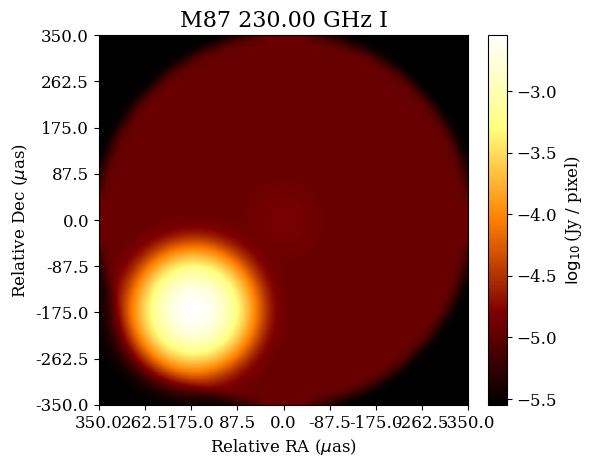

In [102]:
gaussprior.display(scale='log');

In [103]:
# Add non-closing systematic noise to the observation
obs_sc = obs_sc.add_fractional_noise(sys_noise)

In [104]:
# Make a copy of the initial data (before any self-calibration but after the taper)
obs_sc_init = obs_sc.copy()

In [107]:
obs_sc_init.data

array([(1.38902664e-03, 0., 'AA', 'AP', 0.12      , 0.12      ,  8.72307487e+05, -1.77677099e+06,  0.75837346-0.00732415j,  9.59871224e-05-8.60793484e-05j,  1.67695559e-04-8.70673642e-05j,  9.18557247e-05-7.87520083e-05j, 0.00758484, 0.00758484, 0.00758484, 0.00758484),
       (1.38902664e-03, 0., 'AA', 'CI', 0.12      , 0.31999999, -2.96584957e+09, -3.69146851e+09,  0.10037166-0.00906219j, -1.16966028e-04-4.03396738e-04j, -1.58964265e-04+1.41899320e-05j, -3.38805839e-05-5.48351144e-04j, 0.00103325, 0.00103325, 0.00103325, 0.00103325),
       (1.38902664e-03, 0., 'AA', 'GB', 0.12      , 1.12      , -5.55344836e+09,  5.21749114e+08, -0.00098968-0.04711375j, -2.68137924e-04+1.21802236e-04j,  2.14636090e-04-1.02708425e-04j, -5.60930229e-05+2.16904407e-04j, 0.00049889, 0.00049889, 0.00049889, 0.00049889),
       ...,
       (2.36680555e+01, 0., 'PV', 'CI', 0.40000001, 0.31999999,  1.09524383e+09,  5.93506342e+08, -0.14437805-0.38189549j, -4.72182825e-04-1.30912781e-03j, -5.86438920e-04+6.3

In [108]:
obs_sc_init.data.shape

(3592,)

## Image reconstruction

Round 1: Imaging with complex visibilities amplitudes and closure quantities...
Initializing imager data products . . .
Imager run 1 
Imaging . . .
time: 12.062862 s
J: 5.420656
chi2_amp : 1.53 chi2_cphase : 2.03 chi2_logcamp : 0.93 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


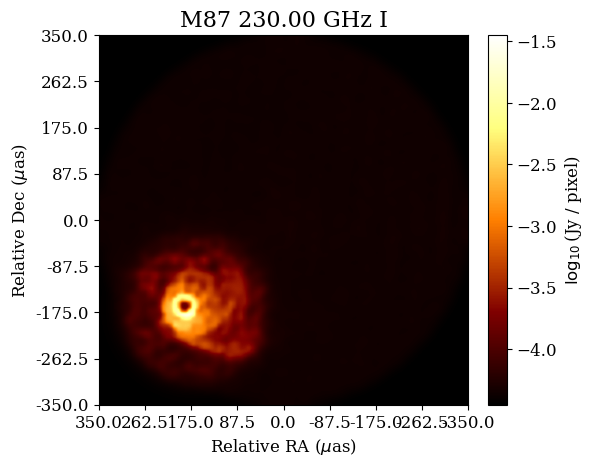

Imager run 2 
Imaging . . .
time: 12.121462 s
J: 4.410842
chi2_amp : 1.12 chi2_cphase : 1.77 chi2_logcamp : 0.62 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


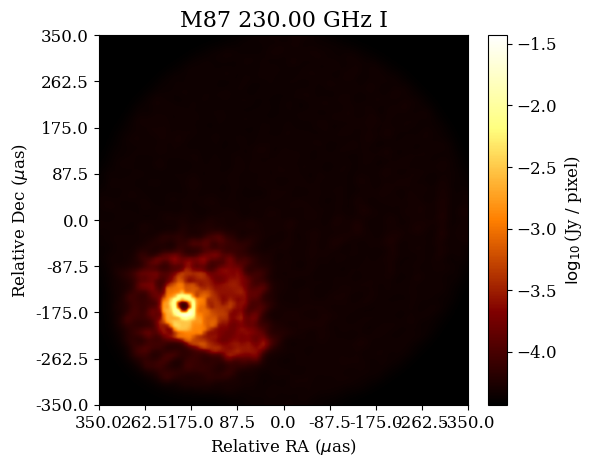

Imager run 3 
Imaging . . .
time: 12.156395 s
J: 3.978977
chi2_amp : 0.91 chi2_cphase : 1.67 chi2_logcamp : 0.51 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


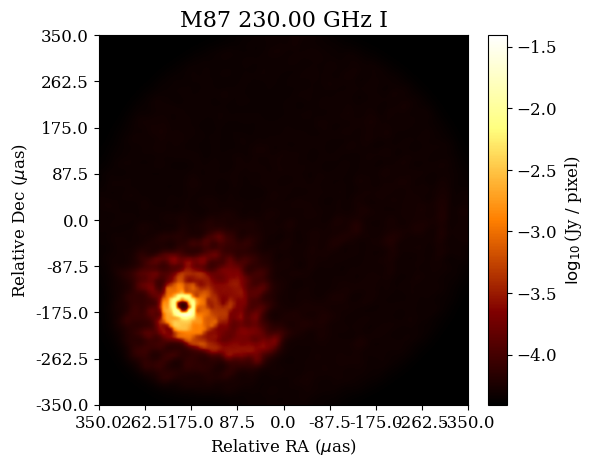

Imager run 4 
Imaging . . .
time: 11.263842 s
J: 3.680804
chi2_amp : 0.75 chi2_cphase : 1.58 chi2_logcamp : 0.44 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


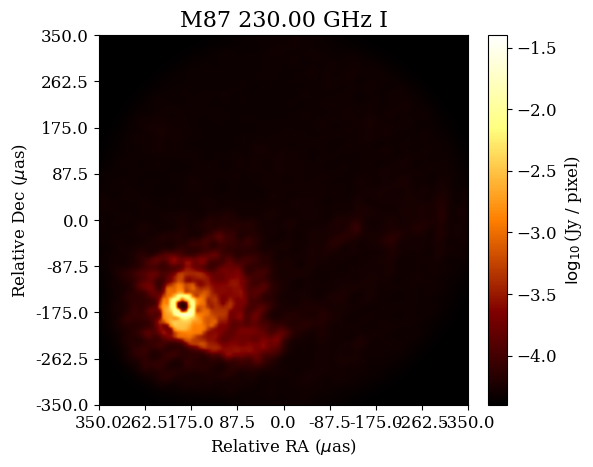

Imager run 5 
Imaging . . .
time: 11.636700 s
J: 3.475246
chi2_amp : 0.66 chi2_cphase : 1.54 chi2_logcamp : 0.40 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


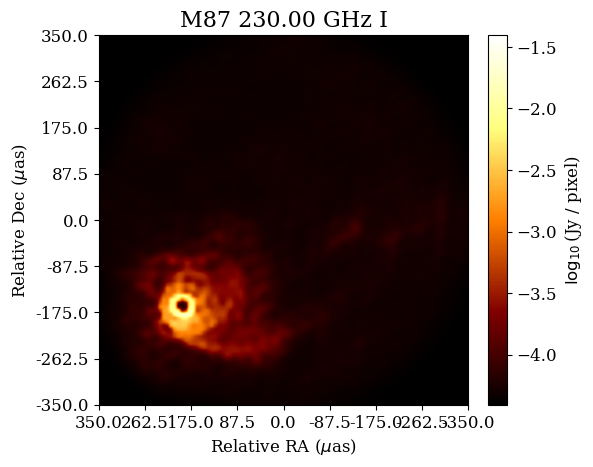

In [111]:
# First  Round of Imaging
# ·······················
print("Round 1: Imaging with complex visibilities amplitudes and closure quantities...")

# Initialize imaging with a Gaussian image
imgr = eh.imager.Imager(obs_sc, 
                        gaussprior, 
                        prior_im=gaussprior,
                        flux=zbl, 
                        data_term=data_term, maxit=maxit,
                        norm_reg=True, reg_term=reg_term, ttype=ttype,
                        stop=stop)

# Imaging
imgr.make_image_I(show_updates=False)
imgr.out_last().display(scale='log')
imgr = converge(imgr)

# Self-calibrate to the previous model
# obs_sc = eh.selfcal(obs_sc_init, imgr.out_last(), method='both', ttype=ttype, solution_interval=0.0, processes=0)

In [113]:
# Self-calibrate to the previous model
obs_sc = eh.selfcal(obs_sc_init, 
                    imgr.out_last(), 
                    method='both', 
                    ttype=ttype, 
                    solution_interval=0.0, 
                    processes=-1)

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with nfft Fourier Transform...
Producing clean visibilities from image with nfft FT . . . 
Not Using Multiprocessing
Scan 66/67 : [----------------------------- ]98%
self_cal time: 15.458374 s


Round 2: Imaging with visibilities and closure quantities...
Initializing imager data products . . .
Imager run 1 
Imaging . . .
time: 12.452039 s
J: 1.480192
chi2_cphase : 1.34 chi2_logcamp : 0.39 chi2_vis : 0.99 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
Imaging . . .
time: 12.129999 s
J: 0.759024
chi2_cphase : 1.30 chi2_logcamp : 0.38 chi2_vis : 0.96 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


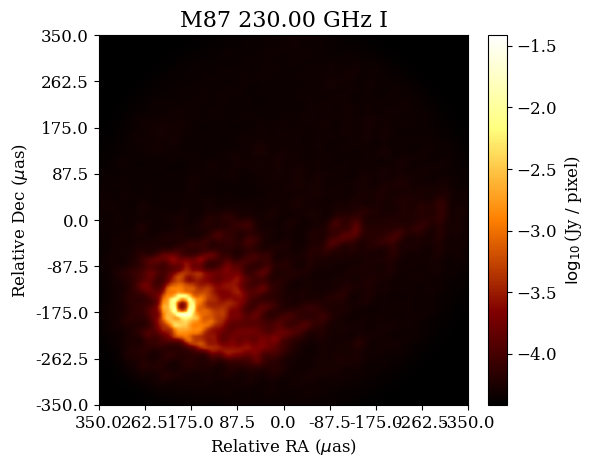

Imager run 3 
Imaging . . .
time: 12.392436 s
J: 0.328721
chi2_cphase : 1.28 chi2_logcamp : 0.37 chi2_vis : 0.95 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


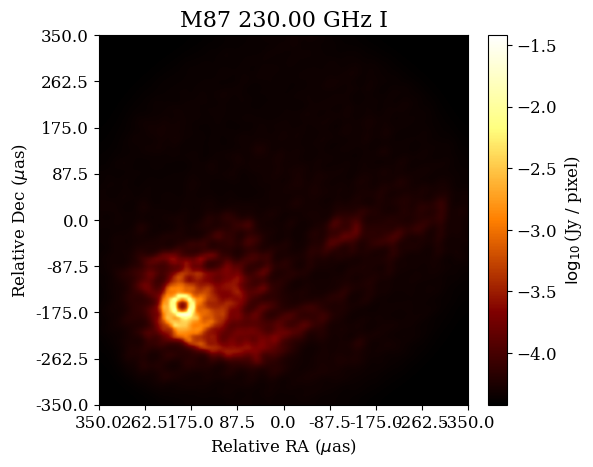

Imager run 4 
Imaging . . .
time: 12.557532 s
J: -0.200284
chi2_cphase : 1.25 chi2_logcamp : 0.36 chi2_vis : 0.94 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


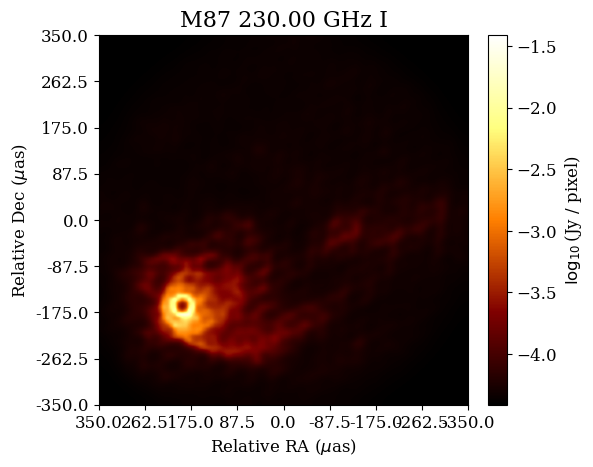

Imager run 5 
Imaging . . .
time: 12.373811 s
J: -0.183288
chi2_cphase : 1.25 chi2_logcamp : 0.36 chi2_vis : 0.93 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


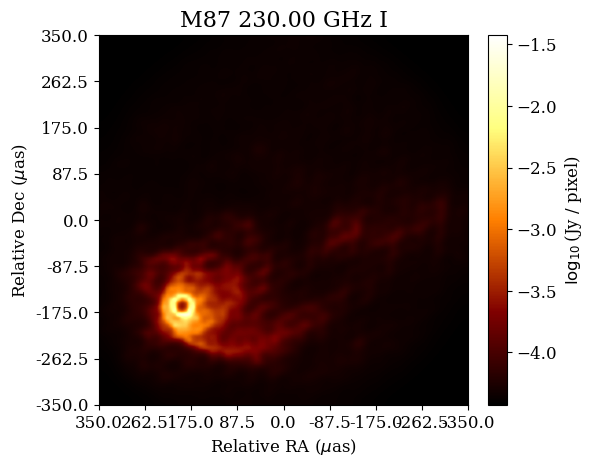

In [114]:
# Second  Round of Imaging
# ························
print("Round 2: Imaging with visibilities and closure quantities...")

# Blur the previous reconstruction to the intrinsic resolution of ~25 uas
init = imgr.out_last().blur_circ(res)

# Increase the weights on the data terms and reinitialize imaging
data_term_intermediate = {'vis':imgr.dat_terms_last()['amp']*10,
                          'cphase':imgr.dat_terms_last()['cphase']*10,
                          'logcamp':imgr.dat_terms_last()['logcamp']*10}


imgr2 = eh.imager.Imager(obs_sc, init, prior_im=gaussprior, flux=zbl,
                        data_term=data_term_intermediate, maxit=maxit, 
                        norm_reg=True, reg_term=reg_term, ttype=ttype,
                        stop=stop)

# Imaging
imgr2.make_image_I(show_updates=False)
imgr2 = converge(imgr2)



In [115]:
# Self-calibrate to the previous model starting from scratch
obs_sc = eh.selfcal(obs_sc_init, 
                    imgr2.out_last(), 
                    method='both', 
                    ttype=ttype,
                    solution_interval=0.0, 
                    processes=-1)

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with nfft Fourier Transform...
Producing clean visibilities from image with nfft FT . . . 
Not Using Multiprocessing
Scan 66/67 : [----------------------------- ]98%
self_cal time: 15.638412 s


## Output the results

/Users/younghokim/anaconda3/envs/astropy2/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Building NX table
No NX table in saved uvfits


/Users/younghokim/anaconda3/envs/astropy2/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/younghokim/anaconda3/envs/astropy2/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


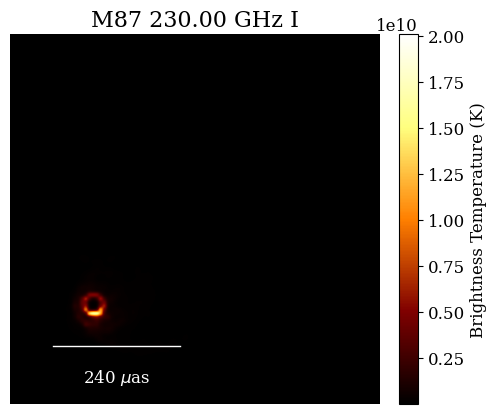

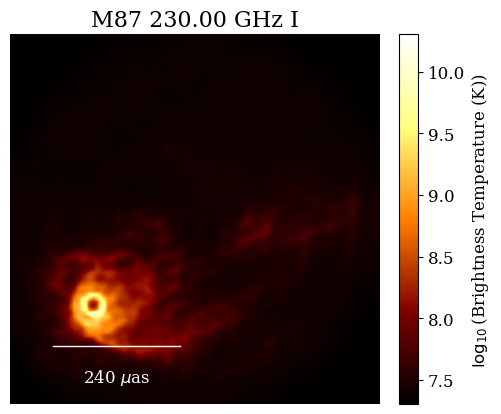

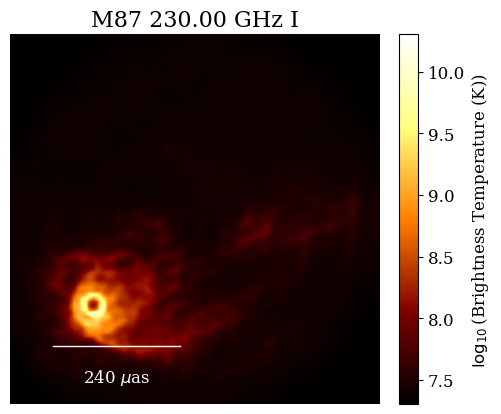

In [116]:
# Save the reconstructed image
im_out = imgr2.out_last().copy()
obs_sc_final = obs_sc.copy()

# Save the final image
im_out.save_fits(outpath+'.fits')
obs_sc_final.save_uvfits(outpath+'.uvfits')

# Save a png of the final image
im_out.display(cbar_unit=['Tb'], label_type='scale', export_pdf=outpath+'.png')
im_out.display(cbar_unit=['Tb'], label_type='scale', scale='log', export_pdf=outpath+'_logscale.png')

# Generate a summary of the final image and associated data consistency metrics (might take a while)
#eh.imgsum(im_out, obs_sc_final, obs_orig, outpath+'_imgsum.pdf', gainplots=False)

## Check image fit to data

Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Warning!: in add_noise, some SEFDs are <= 0!
NOT recomputing sigmas, which may result in double systematic noise


/Users/younghokim/anaconda3/envs/astropy2/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 3592 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/younghokim/anaconda3/envs/astropy2/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 3592 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


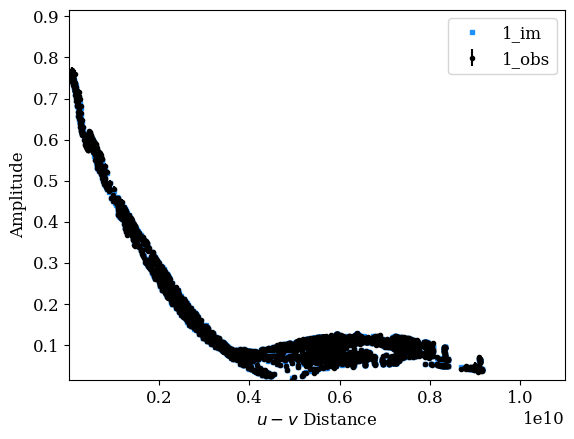

Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Warning!: in add_noise, some SEFDs are <= 0!
NOT recomputing sigmas, which may result in double systematic noise


/Users/younghokim/anaconda3/envs/astropy2/lib/python3.11/site-packages/ehtim/obsdata.py:2851: RuntimeWarning: divide by zero encountered in scalar divide
  if np.abs(bi) / bisig < snrcut:


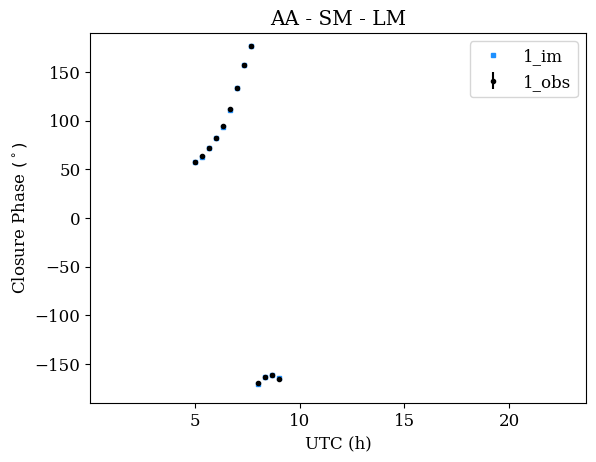

<Axes: title={'center': 'AA - SM - LM'}, xlabel='UTC (h)', ylabel='Closure Phase $(^\\circ)$'>

In [117]:
# Plot self-calibrated visibility amplitudes and image model
eh.plotall_obs_im_compare(obs_sc_final, im_out, 'uvdist', 'amp')

# Plot closure phases and image model
eh.plot_cphase_obs_im_compare(obs_sc_final, im_out, 'AA', 'SM', 'LM')